In [12]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import librosa
import librosa.display
import soundfile
from IPython.display import Audio

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

data_dir = Path('../artifacts/dataset')

for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

..\artifacts\dataset\DATASET DETAILS ABVV.xlsx
..\artifacts\dataset\dataset sentences and details.docx
..\artifacts\dataset\1\session1\anger\1.1.anger-01.wav
..\artifacts\dataset\1\session1\anger\1.1.anger-02.wav
..\artifacts\dataset\1\session1\anger\1.1.anger-03.wav
..\artifacts\dataset\1\session1\anger\1.1.anger-04.wav
..\artifacts\dataset\1\session1\anger\1.1.anger-05.wav
..\artifacts\dataset\1\session1\anger\1.1.anger-06.wav
..\artifacts\dataset\1\session1\anger\1.1.anger-07.wav
..\artifacts\dataset\1\session1\anger\1.1.anger-08.wav
..\artifacts\dataset\1\session1\anger\1.1.anger-09.wav
..\artifacts\dataset\1\session1\anger\1.1.anger-10.wav
..\artifacts\dataset\1\session1\disgust\1.1.disgust-01.wav
..\artifacts\dataset\1\session1\disgust\1.1.disgust-02.wav
..\artifacts\dataset\1\session1\disgust\1.1.disgust-03.wav
..\artifacts\dataset\1\session1\disgust\1.1.disgust-04.wav
..\artifacts\dataset\1\session1\disgust\1.1.disgust-05.wav
..\artifacts\dataset\1\session1\disgust\1.1.disgust-

In [3]:
paths = []
labels = []

# Walk through the dataset directory
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        # Extract the emotion label from the filename
        label = filename.split('_')[-1]
        # Remove the file extension if it's present
        label = label.split('.')[0].lower()
        
        # Append the full file path to paths and the extracted label to labels
        paths.append(os.path.join(dirname, filename))
        labels.append(label)

print('Dataset is Loaded')

Dataset is Loaded


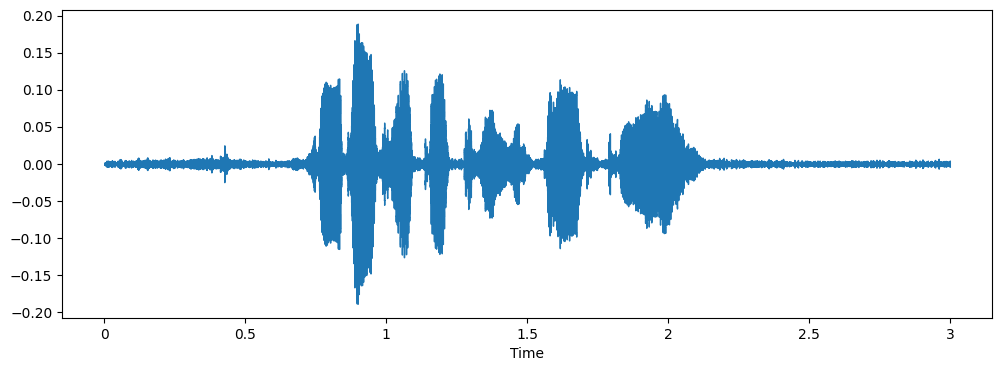

In [4]:
data, sampling_rate = librosa.load('../artifacts/dataset/1/session1/anger/1.1.anger-01.wav')

plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)

In [5]:
# all emotions in the new dataset
int2emotion_new = {
    "anger": "angry",
    "disgust": "disgust",
    "fear": "afraid",
    "happy": "happy",
    "neutral": "calm",
    "sad": "sad",
    "sarcastic": "sarcastic",
    "surprise": "surprise",
}

# we allow only these four emotions
AVAILABLE_EMOTIONS_NEW = set(int2emotion_new.values())

def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
    Features supported:
        - MFCC (mfcc)
        - Chroma (chroma)
        - MEL Spectrogram Frequency (mel)
        - Contrast (contrast)
        - Tonnetz (tonnetz)
    e.g:
    `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
            
        result = np.array([])
        
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
            
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
            
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast))
            
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz))
            
    return result

def load_data_new(test_size=0.2):
    X, y = [], []

    try:
        dataset_path = '../artifacts/dataset/**/*.wav'

        for file_name in glob.glob(dataset_path, recursive=True):
            # get the emotion label from the path
            emotion_folder = os.path.basename(os.path.dirname(file_name))
            emotion = int2emotion_new.get(emotion_folder)
            
            # check if the emotion is in the allowed set
            if emotion not in AVAILABLE_EMOTIONS_NEW:
                continue

            # extract speech features
            features = extract_feature(file_name, mfcc=True, chroma=True, mel=True)

            # add to data
            X.append(features)
            y.append(emotion)

    except Exception as e:
        print(f"Error: {e}")

    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

X_train_new, X_test_new, y_train_new, y_test_new = load_data_new()

Accuracy: 0.4703125


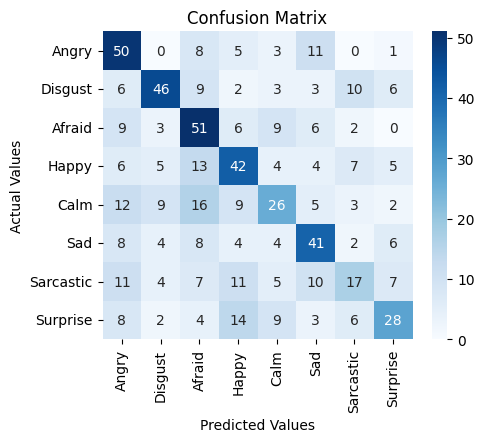

Classification Report:
               precision    recall  f1-score   support

       Angry       0.45      0.64      0.53        78
     Disgust       0.63      0.54      0.58        85
      Afraid       0.44      0.59      0.50        86
       Happy       0.45      0.49      0.47        86
        Calm       0.41      0.32      0.36        82
         Sad       0.49      0.53      0.51        77
   Sarcastic       0.36      0.24      0.29        72
    Surprise       0.51      0.38      0.43        74

    accuracy                           0.47       640
   macro avg       0.47      0.47      0.46       640
weighted avg       0.47      0.47      0.46       640



In [6]:
def train_and_evaluate_knn(X_train, y_train, X_test, y_test, n_neighbors=7, emotion_labels=None):
    """
    Train and evaluate a KNN classifier on the given dataset.
    
    Parameters:
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_test (array-like): Testing features.
        y_test (array-like): Testing labels.
        n_neighbors (int): Number of neighbors for KNN. Default is 7.
        emotion_labels (list): List of emotion labels for the confusion matrix. Default is None.
    
    Returns:
        dict: A dictionary containing the trained model, accuracy, confusion matrix, and classification report.
    """
    # Train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    # Evaluate accuracy
    accuracy = knn.score(X_test, y_test)
    print("Accuracy:", accuracy)
    
    # Predictions and confusion matrix
    knn_predictions = knn.predict(X_test)
    cmm = confusion_matrix(y_test, knn_predictions)
    
    # Plot confusion matrix if emotion labels are provided
    if emotion_labels:
        cm_df = pd.DataFrame(cmm, index=emotion_labels, columns=emotion_labels)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
    # Classification report
    report = classification_report(y_test, knn_predictions, target_names=emotion_labels) if emotion_labels else classification_report(y_test, knn_predictions)
    print("Classification Report:\n", report)
    
    # Return results
    return {
        "model": knn,
        "accuracy": accuracy,
        "confusion_matrix": cmm,
        "classification_report": report
    }

emotions = ["Angry", "Disgust", "Afraid", "Happy", "Calm", "Sad", "Sarcastic", "Surprise"]
results = train_and_evaluate_knn(X_train_new, y_train_new, X_test_new, y_test_new, n_neighbors=7, emotion_labels=emotions)

Accuracy: 0.64375


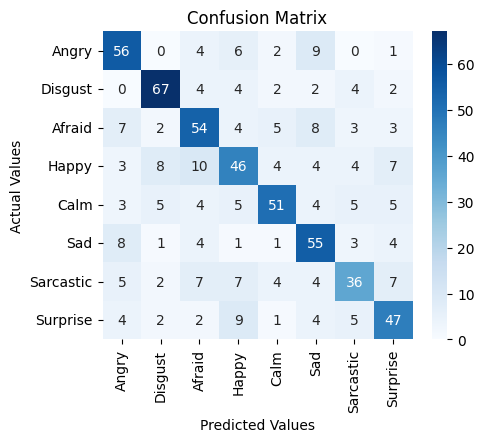

Classification Report:
               precision    recall  f1-score   support

       Angry       0.65      0.72      0.68        78
     Disgust       0.77      0.79      0.78        85
      Afraid       0.61      0.63      0.62        86
       Happy       0.56      0.53      0.55        86
        Calm       0.73      0.62      0.67        82
         Sad       0.61      0.71      0.66        77
   Sarcastic       0.60      0.50      0.55        72
    Surprise       0.62      0.64      0.63        74

    accuracy                           0.64       640
   macro avg       0.64      0.64      0.64       640
weighted avg       0.64      0.64      0.64       640



In [7]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, n_estimators=150, random_state=0, emotion_labels=None):
    """
    Train and evaluate a Random Forest classifier on the given dataset.
    
    Parameters:
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_test (array-like): Testing features.
        y_test (array-like): Testing labels.
        n_estimators (int): Number of trees in the forest. Default is 150.
        random_state (int): Random state for reproducibility. Default is 0.
        emotion_labels (list): List of emotion labels for the confusion matrix. Default is None.
    
    Returns:
        dict: A dictionary containing the trained model, accuracy, confusion matrix, and classification report.
    """
    # Create Random Forest classifier
    classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    
    # Fit the classifier
    classifier.fit(X_train, y_train)
    
    # Predict on test data
    predictions = classifier.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
    print("Accuracy:", accuracy)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Plot confusion matrix if emotion labels are provided
    if emotion_labels:
        cm_df = pd.DataFrame(cm, index=emotion_labels, columns=emotion_labels)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
    # Classification report
    report = classification_report(y_test, predictions, target_names=emotion_labels) if emotion_labels else classification_report(y_test, predictions)
    print("Classification Report:\n", report)
    
    # Return results
    return {
        "model": classifier,
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "classification_report": report
    }

emotions = ["Angry", "Disgust", "Afraid", "Happy", "Calm", "Sad", "Sarcastic", "Surprise"]
results = train_and_evaluate_rf(X_train_new, y_train_new, X_test_new, y_test_new, n_estimators=150, random_state=0, emotion_labels=emotions)

[*] Training the MLP model...
Accuracy: 56.09%


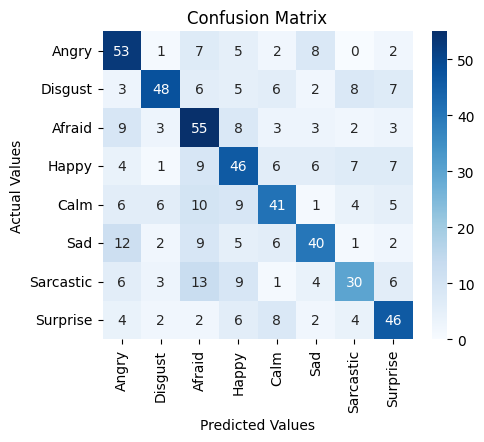

Classification Report:
               precision    recall  f1-score   support

       Angry       0.55      0.68      0.61        78
     Disgust       0.73      0.56      0.64        85
      Afraid       0.50      0.64      0.56        86
       Happy       0.49      0.53      0.51        86
        Calm       0.56      0.50      0.53        82
         Sad       0.61      0.52      0.56        77
   Sarcastic       0.54      0.42      0.47        72
    Surprise       0.59      0.62      0.61        74

    accuracy                           0.56       640
   macro avg       0.57      0.56      0.56       640
weighted avg       0.57      0.56      0.56       640



In [9]:
def train_and_evaluate_mlp(X_train, y_train, X_test, y_test, emotion_labels=None, model_params=None):
    """
    Train and evaluate a Multi-Layer Perceptron (MLP) classifier on the given dataset.
    
    Parameters:
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_test (array-like): Testing features.
        y_test (array-like): Testing labels.
        emotion_labels (list): List of emotion labels for the confusion matrix. Default is None.
        model_params (dict): Parameters for the MLPClassifier. Default is None.
    
    Returns:
        dict: A dictionary containing the trained model, accuracy, confusion matrix, and classification report.
    """
    if model_params is None:
        model_params = {
            'alpha': 0.01,
            'batch_size': 256,
            'epsilon': 1e-08,
            'hidden_layer_sizes': (300,),
            'learning_rate': 'adaptive',
            'max_iter': 500,
        }
    
    # Initialize and train the MLP model
    print("[*] Training the MLP model...")
    mlp_model = MLPClassifier(**model_params)
    mlp_model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = mlp_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix if emotion labels are provided
    if emotion_labels:
        cm_df = pd.DataFrame(cm, index=emotion_labels, columns=emotion_labels)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    
    # Classification report
    report = classification_report(y_test, y_pred, target_names=emotion_labels) if emotion_labels else classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # Return results
    return {
        "model": mlp_model,
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "classification_report": report
    }

emotions = ["Angry", "Disgust", "Afraid", "Happy", "Calm", "Sad", "Sarcastic", "Surprise"]
mlp_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08,
    'hidden_layer_sizes': (300,),
    'learning_rate': 'adaptive',
    'max_iter': 500,
}
results = train_and_evaluate_mlp(X_train_new, y_train_new, X_test_new, y_test_new, emotion_labels=emotions, model_params=mlp_params)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 138, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 69, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 67, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 33, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 31, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       983,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,488 (4.38 MB)

 Trainable params: 1,148,488 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.1270 - loss: 2.1785 - precision_1: 0.2400 - recall_1: 0.0095 - val_accuracy: 0.2168 - val_loss: 2.0266 - val_precision_1: 0.8333 - val_recall_1: 0.0098
Epoch 2/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1886 - loss: 2.0500 - precision_1: 0.5276 - recall_1: 0.0079 - val_accuracy: 0.2109 - val_loss: 1.9539 - val_precision_1: 0.8571 - val_recall_1: 0.0352
Epoch 3/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2064 - loss: 2.0060 - precision_1: 0.5879 - recall_1: 0.0236 - val_accuracy: 0.2480 - val_loss: 1.8891 - val_precision_1: 0.7857 - val_recall_1: 0.0430
Epoch 4/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2249 - loss: 1.9313 - precision_1: 0.6454 - recall_1: 0.0338 - val_accuracy: 0.2832 - val_loss: 1.8404 - val_precision_1: 0.6957 - val_recall_1: 0.0625
Epoch 5/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2731 - loss: 1.8388 - precision_1: 0.6919 - recall_1: 0.0690 - val_

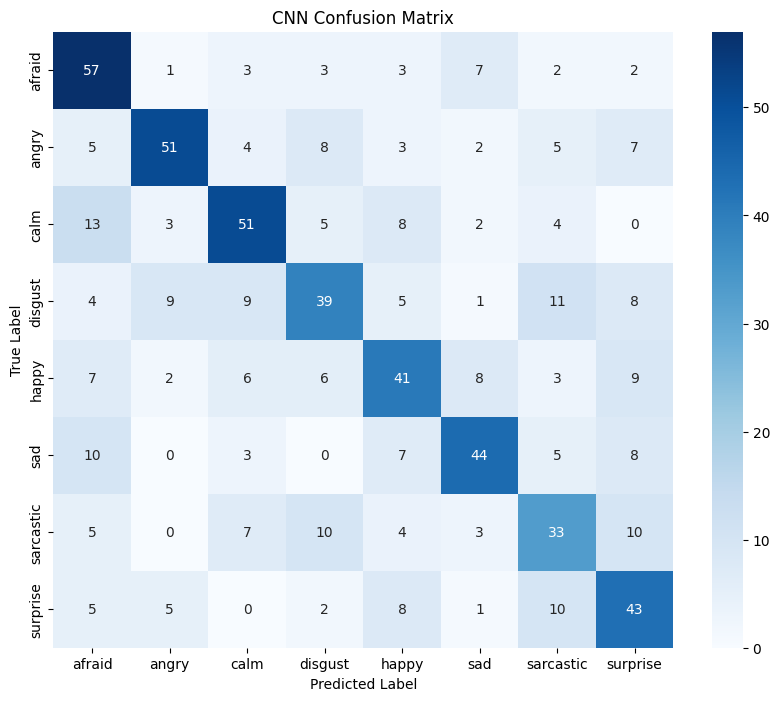

In [14]:
def train_evaluate_cnn(X_train, y_train, X_test, y_test, num_classes, label_classes, input_shape=None, epochs=50, batch_size=32):
    """
    Train and evaluate a CNN model.
    
    Parameters:
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_test (array-like): Testing features.
        y_test (array-like): Testing labels.
        num_classes (int): Number of output classes.
        label_classes (list): List of class labels for evaluation.
        input_shape (tuple): Shape of input data (default: derived from X_train).
        epochs (int): Number of training epochs (default: 50).
        batch_size (int): Batch size for training (default: 32).
        
    Returns:
        model: Trained CNN model.
    """
    if input_shape is None:
        input_shape = (X_train.shape[1], 1)

    # Create CNN model
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.1),
        
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            ]
    )

    model.summary()

    # Train the model
    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Print classification report
    print("\nCNN Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=label_classes))

    # Confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
    plt.title('CNN Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return model

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_new)
y_test_encoded = le.transform(y_test_new)

# Convert to categorical
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

# Reshape input data
X_train_reshaped = X_train_new.reshape(X_train_new.shape[0], X_train_new.shape[1], 1)
X_test_reshaped = X_test_new.reshape(X_test_new.shape[0], X_test_new.shape[1], 1)

num_classes = len(np.unique(y_train_encoded))
label_classes = le.classes_

# Train and evaluate the CNN
cnn_model = train_evaluate_cnn(
    X_train_reshaped, y_train_cat,
    X_test_reshaped, y_test_cat,
    num_classes=num_classes,
    label_classes=label_classes,
    epochs=80,
    batch_size=32
)

In [15]:
from nbconvert import ScriptExporter
import nbformat

# Path to your .ipynb file
input_path = "comp_trials.ipynb"
output_path = "comp_trials.py"

# Load the notebook
with open(input_path, "r", encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

# Convert to .py script
script_exporter = ScriptExporter()
script, _ = script_exporter.from_notebook_node(notebook)

# Save to .py file
with open(output_path, "w", encoding="utf-8") as f:
    f.write(script)

print(f"Converted {input_path} to {output_path}")

Converted comp_trials.ipynb to comp_trials.py
